In [1]:
from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from torch.utils.tensorboard import SummaryWriter

In [2]:
runs = 0
# Define data paths and classes
PATH = '/home/ubuntu/Repos/Data/PIM_Dataset/'
TRAIN_PATH = PATH + '/train'
TEST_PATH = PATH + 'val'
classes = ('good','bad')

SAMPLE_PATH = '/home/ubuntu/Repos/Data/PIM_Dataset/test/chared144_1.bmp'

In [3]:
!pwd
!ls /home/ubuntu/Repos/Data/PIM_Dataset/train
# chared144_1.bmp: PC bitmap, Windows 98/2000 and newer format, 514 x 429 x 24

/home/ubuntu/Repos/udemy_tut/resnet_hack
bad  good


'Windows Bitmap'

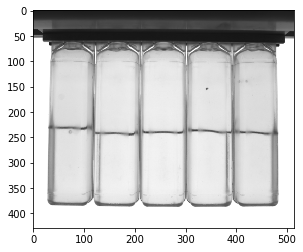

In [4]:
%matplotlib inline
pil_im = Image.open(SAMPLE_PATH, 'r')
plt.imshow(np.asarray(pil_im))
pil_im.format_description

In [5]:
im_arr = np.array(pil_im)
print(im_arr.shape)
print(pil_im)

(429, 514, 3)
<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=514x429 at 0x7F0314764350>


In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]);

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
input_tensor = preprocess(pil_im)
input_batch = input_tensor.unsqueeze(0)
print(pil_im)
print(input_batch.shape)

<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=514x429 at 0x7F0314764350>
torch.Size([1, 3, 224, 224])


In [8]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False, num_classes=2)
model.eval();

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


In [9]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with torch.no_grad():
    output = model(input_batch)
print(output[0])
print(torch.nn.functional.softmax(output[0], dim=0));



tensor([-0.8363, -0.4357], device='cuda:0')
tensor([0.4012, 0.5988], device='cuda:0')


In [10]:

image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


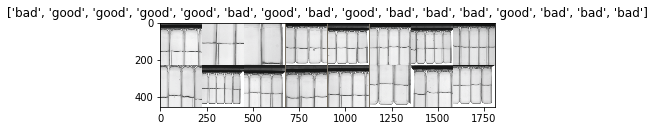

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [12]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    #print("TP: %.4f, FP: %.4f, TN: %.4f, FN: %.4f" % (TP, FP, TN, FN))
    return torch.Tensor([TP, FP, TN, FN])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    infos_train = [np.zeros(6)]
    infos_val = [np.zeros(6)]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        #ACC, PPV, TPR, TNR, F1


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            measures = torch.zeros(4)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                measures = measures + perf_measure(labels.data, preds)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            TP,FP,TN,FN = measures[0], measures[1], measures[2], measures[3]
            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
            # Specificity or true negative rate
            TNR = TN/(TN+FP)
            # Precision or positive predictive value
            PPV = TP/(TP+FP)
            # Negative predictive value
            NPV = TN/(TN+FN)
            # Fall out or false positive rate
            FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
            # False discovery rate
            FDR = FP/(TP+FP)

            # F1 Score
            F1 = 2 * (TPR * PPV) / (TPR + PPV)

            # Overall accuracy
            ACC = (TP+TN)/(TP+FP+FN+TN)
            print('phase:',phase)
            #print("TPR: %.4f, TNR: %.4f, PPV: %.4f, NPV: %.4f, FPR: %.4f, FNR: %.4f, FDR: %.4f, ACC: %.4f"
            #      % (TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC))
            print("ACC: %.4f, PPV: %.4f, TPR: %.4f, \nTNR: %.4f, F1: %.4f, FPR: %.4f"
                 % (ACC, PPV, TPR, TNR, F1, FPR))
            if phase == 'train':
                infos_train.append([ACC, PPV, TPR, TNR, F1, FPR])
            if phase == 'val':
                infos_val.append([ACC, PPV, TPR, TNR, F1, FPR])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # relevant:
            # conf matrix plot
            # ACC, PPV, TPR, TNR, F1
            # acc
            # precision
            # recall
            # f1  score
            # speific

            # am wichtigsten: Kein bad darf als positive classifiziert werden

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, infos_train, infos_val

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [17]:
from torchvision import datasets, models, transforms

model_ft = models.wide_resnet50_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=14, gamma=0.2)



In [18]:
writer = SummaryWriter('runs/binary_fault_detection_' + str(runs))
runs += 1

In [19]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

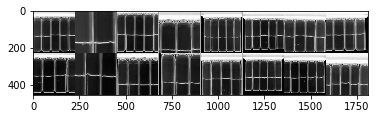

In [20]:
# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('chared144_1', img_grid)

In [21]:
model_ft, infos_train, infos_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=9)

Epoch 0/8
----------
phase: train
ACC: 0.8386, PPV: 0.8499, TPR: 0.8705, 
TNR: 0.7964, F1: 0.8601, FPR: 0.2036
train Loss: 0.3582 Acc: 0.8386
phase: val
ACC: 0.9215, PPV: 0.9868, TPR: 0.8739, 
TNR: 0.9845, F1: 0.9269, FPR: 0.0155
val Loss: 0.2222 Acc: 0.9215
Epoch 1/8
----------
phase: train
ACC: 0.9267, PPV: 0.9345, TPR: 0.9371, 
TNR: 0.9131, F1: 0.9358, FPR: 0.0869
train Loss: 0.1985 Acc: 0.9267
phase: val
ACC: 0.9190, PPV: 0.8778, TPR: 0.9964, 
TNR: 0.8167, F1: 0.9333, FPR: 0.1833
val Loss: 0.1909 Acc: 0.9190
Epoch 2/8
----------
phase: train
ACC: 0.9477, PPV: 0.9566, TPR: 0.9514, 
TNR: 0.9429, F1: 0.9540, FPR: 0.0571
train Loss: 0.1421 Acc: 0.9477
phase: val
ACC: 0.9836, PPV: 0.9972, TPR: 0.9739, 
TNR: 0.9964, F1: 0.9854, FPR: 0.0036
val Loss: 0.0659 Acc: 0.9836
Epoch 3/8
----------
phase: train
ACC: 0.9631, PPV: 0.9659, TPR: 0.9694, 
TNR: 0.9548, F1: 0.9677, FPR: 0.0452
train Loss: 0.1010 Acc: 0.9631
phase: val
ACC: 0.9851, PPV: 0.9745, TPR: 1.0000, 
TNR: 0.9655, F1: 0.9871, FPR: 

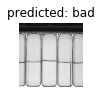

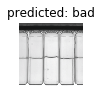

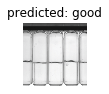

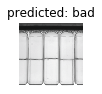

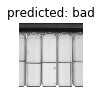

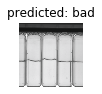

In [22]:
visualize_model(model_ft)


In [23]:
runs = 4
writer = SummaryWriter('runs/binary_fault_detection_' + str(runs))
runs += 1

plot_range = zip(infos_train, infos_val)
for i in range(len(infos_train)):
    (i_train, i_val) = (infos_train[i], infos_val[i])
    #ACC, PPV, TPR, TNR, F1
    writer.add_scalar('Accuracy/train', i_train[0], i)
    writer.add_scalar('Precision/train', i_train[1], i)
    writer.add_scalar('Recall/train', i_train[2], i)
    writer.add_scalar('F1/train', i_train[3], i)
    writer.add_scalar('Accuracy/test', i_val[0], i)
    writer.add_scalar('Precision/test', i_val[1], i)
    writer.add_scalar('Recall/test', i_val[2], i)
    writer.add_scalar('F1/test', i_val[3], i)
    #writer.add_scalar('False positives/train', np.random.random(), i)

In [24]:

len(infos_train)

10

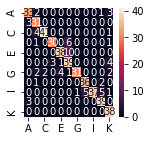

In [25]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[33,2,0,0,0,0,0,0,0,1,3],
        [3,31,0,0,0,0,0,0,0,0,0],
        [0,4,41,0,0,0,0,0,0,0,1],
        [0,1,0,30,0,6,0,0,0,0,1],
        [0,0,0,0,38,10,0,0,0,0,0],
        [0,0,0,3,1,39,0,0,0,0,4],
        [0,2,2,0,4,1,31,0,0,0,2],
        [0,1,0,0,0,0,0,36,0,2,0],
        [0,0,0,0,0,0,1,5,37,5,1],
        [3,0,0,0,0,0,0,0,0,39,0],
        [0,0,0,0,0,0,0,0,0,0,38]]
df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
                  columns = [i for i in "ABCDEFGHIJK"])
plt.figure(figsize = (2,2))
sn.heatmap(df_cm, annot=True)

In [26]:
MODEL_PATH = '/home/ubuntu/Repos/udemy_tut/resnet_hack/model_1'
torch.save(model.state_dict(), MODEL_PATH)

In [27]:
print(num_ftrs)

2048


In [28]:
a_infos_train = np.array(infos_train)
a_infos_test = np.array(infos_val)

In [29]:
a_infos_train.T.shape
a_infos_train.shape

#ACC, PPV, TPR, TNR, F1, FPR

(10, 6)

In [30]:
train_ACC  = np.mean(a_infos_train.T[-10:][0])
train_PREC = np.mean(a_infos_train.T[-10:][1])
train_REC= np.mean(a_infos_train.T[-10:][2])
train_sens = np.mean(a_infos_train.T[-10:][3])
train_F1  = np.mean(a_infos_train.T[-10:][4])
train_fpr = np.mean(a_infos_train.T[-10:][5])


In [31]:
test_ACC  = np.mean(a_infos_test.T[-10:][0])
test_PREC = np.mean(a_infos_test.T[-10:][1])
test_REC= np.mean(a_infos_test.T[-10:][2])
test_sens = np.mean(a_infos_test.T[-10:][3])
test_F1  = np.mean(a_infos_test.T[-10:][4])
test_fpr = np.mean(a_infos_test.T[-10:][5])



In [32]:
print(train_ACC
,train_PREC
,train_REC
,train_sens
,train_F1
,train_fpr)

print(test_ACC
,test_PREC
,test_REC
,test_sens
,test_F1
,test_fpr)

0.8563524544239044 0.8608895063400268 0.8628597140312195 0.8477380931377411 0.8618562459945679 0.05226190481334925
0.8306153893470765 0.8232989430427551 0.8844144165515899 0.7595238134264946 0.8475987195968628 0.14047618822660296


In [33]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val', 'testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'testing']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
infos_train = [np.zeros(6)]
infos_val = [np.zeros(6)]
num_epochs = 1
optimizer = optimizer_ft
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    #ACC, PPV, TPR, TNR, F1
    # Each epoch has a training and validation phase
    for phase in ['testing']:

        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        measures = torch.zeros(4)
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            measures = measures + perf_measure(labels.data, preds)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        TP,FP,TN,FN = measures[0], measures[1], measures[2], measures[3]
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # F1 Score
        F1 = 2 * (TPR * PPV) / (TPR + PPV)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        print('phase:',phase)
        #print("TPR: %.4f, TNR: %.4f, PPV: %.4f, NPV: %.4f, FPR: %.4f, FNR: %.4f, FDR: %.4f, ACC: %.4f"
        #      % (TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC))
        print("ACC: %.4f, PPV: %.4f, TPR: %.4f, \nTNR: %.4f, F1: %.4f, FPR: %.4f"
             % (ACC, PPV, TPR, TNR, F1, FPR))
        if phase == 'train':
            infos_train.append([ACC, PPV, TPR, TNR, F1, FPR])
        if phase == 'val':
            infos_val.append([ACC, PPV, TPR, TNR, F1, FPR])
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))


Epoch 0/0
----------
phase: testing
ACC: 0.5694, PPV: 0.5694, TPR: 1.0000, 
TNR: 0.0000, F1: 0.7257, FPR: 1.0000
testing Loss: 0.6812 Acc: 0.5694
